In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [125]:
#plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

In [150]:
data = pd.read_parquet('/Users/paddy/Documents/GitHub/Masterthesis_ML/data/03_032022_032023_taxi_rides.parquet')
print(data.head())

                       date  count
0 2022-03-31 23:00:00+00:00      1
1 2022-04-01 00:00:00+00:00     26
2 2022-04-01 01:00:00+00:00     15
3 2022-04-01 02:00:00+00:00      5
4 2022-04-01 03:00:00+00:00      1


In [127]:
blocked_data = data.loc[(data['date'] > '2023-01-01') & (data['date'] < '2023-01-31')]


In [128]:
#Set index to date
blocked_data = blocked_data.set_index('date')
data = data.set_index('date') 

In [129]:
#Add time column
data['time'] = np.arange(len(data.index))


Time Plot of rides

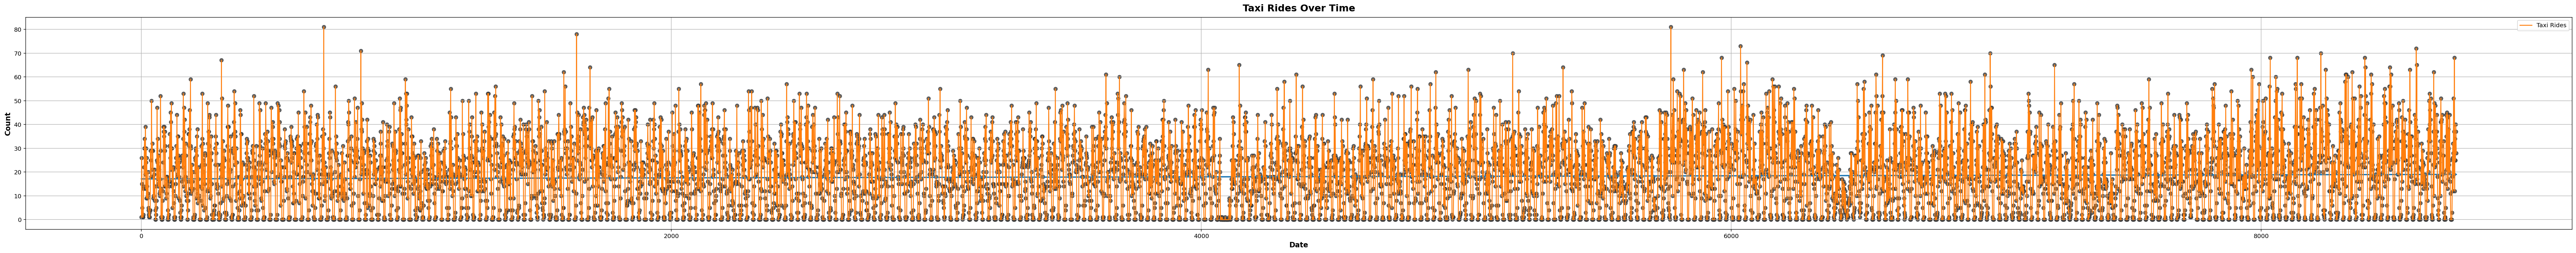

In [130]:
# Plotting the data
plt.figure(figsize=(60, 6))
ax = sns.regplot(x='time', y='count', data=data, ci=None, scatter_kws=dict(color='0.25'))
plt.plot(data['time'], data['count'], label='Taxi Rides')
plt.title('Taxi Rides Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

STL (Seasonal Decomposition)

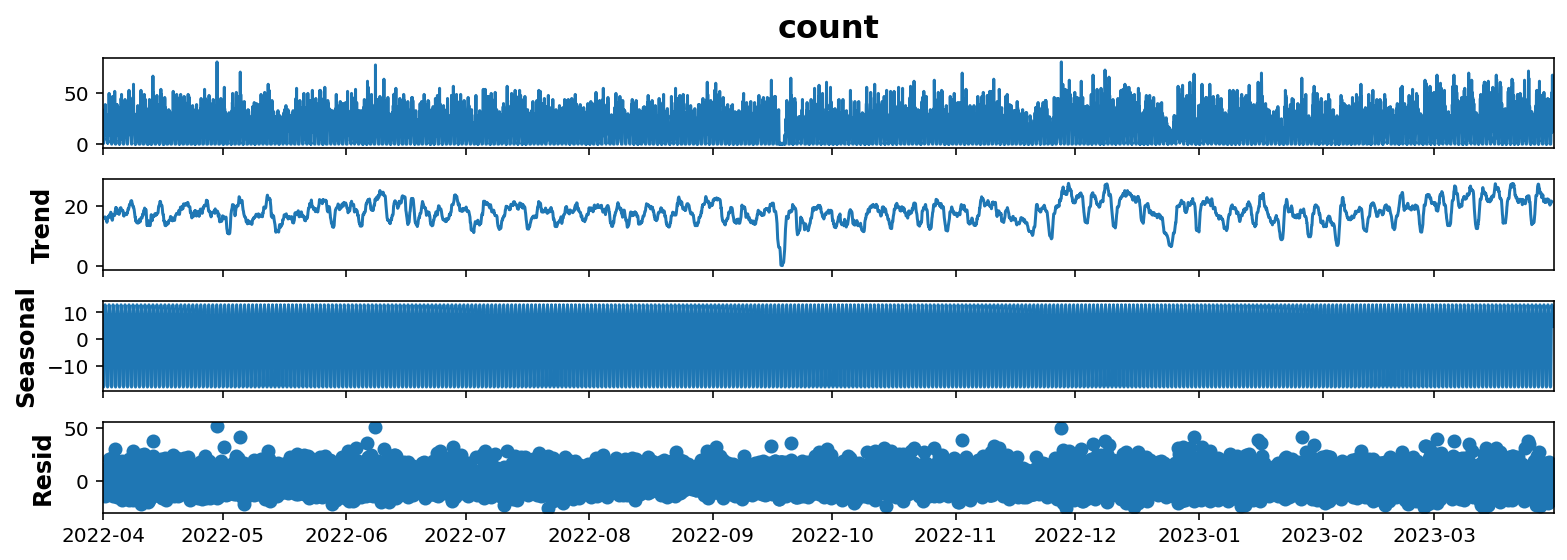

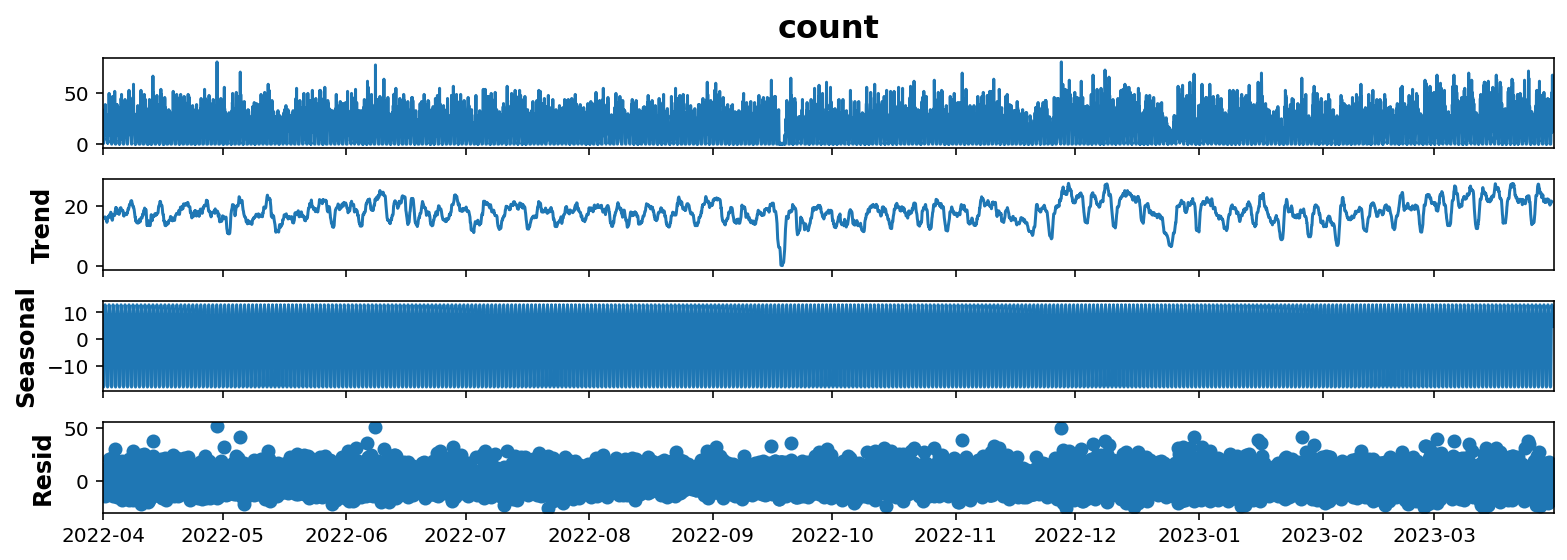

In [131]:
result = seasonal_decompose(data['count'])
result.plot()

Dickey-Fuller Test

In [149]:
X = blocked_data['count'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

dftest = adfuller(X)
adf = dftest[0]
pvalue = dftest[1]
critical_value = dftest[4]['5%']
if (pvalue < 0.05) and (adf < critical_value):
    print('The series is stationary')
else:
    print('The series is NOT stationary')

ADF Statistic: -4.509801
p-value: 0.000189
The series is stationary


Autocorrelation & Partial Autorcorrelation

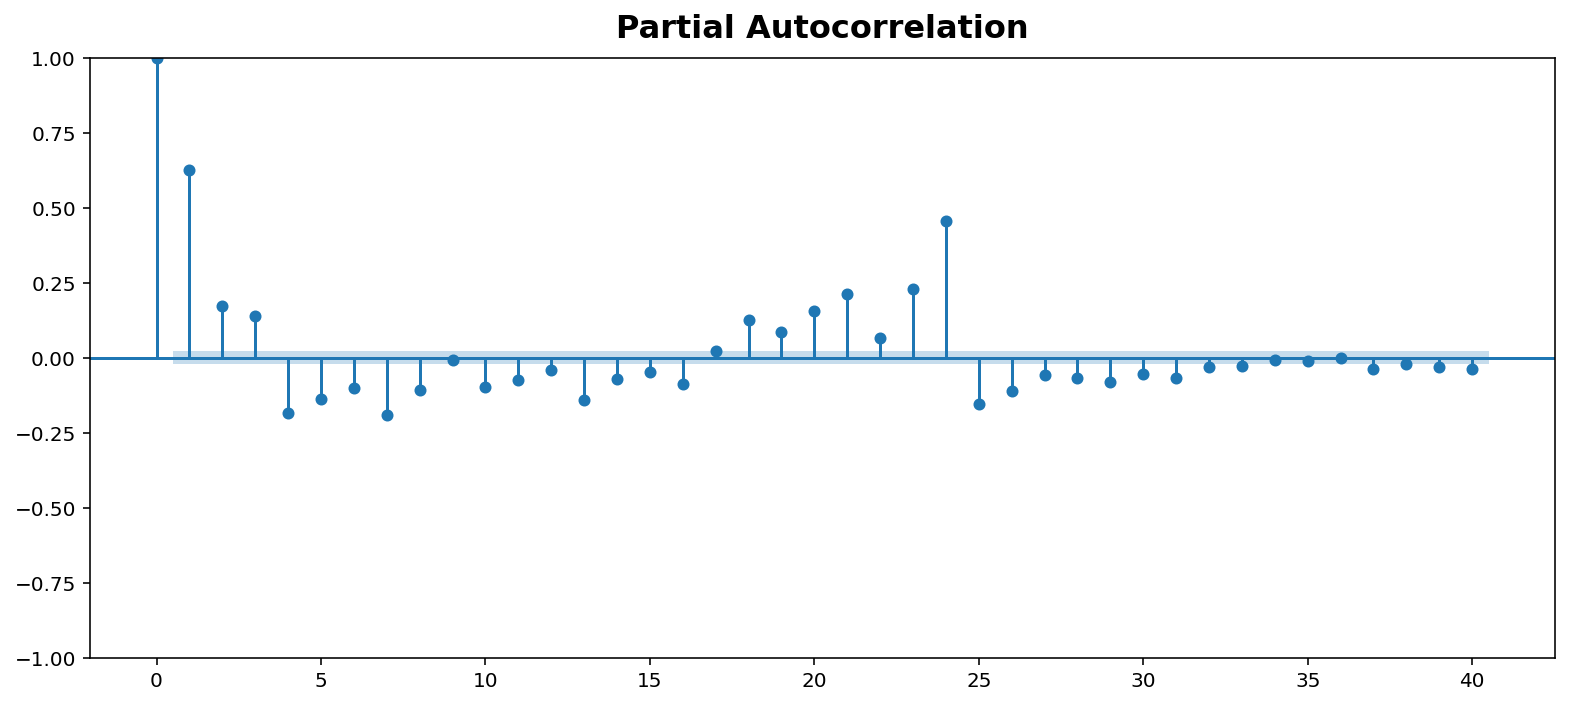

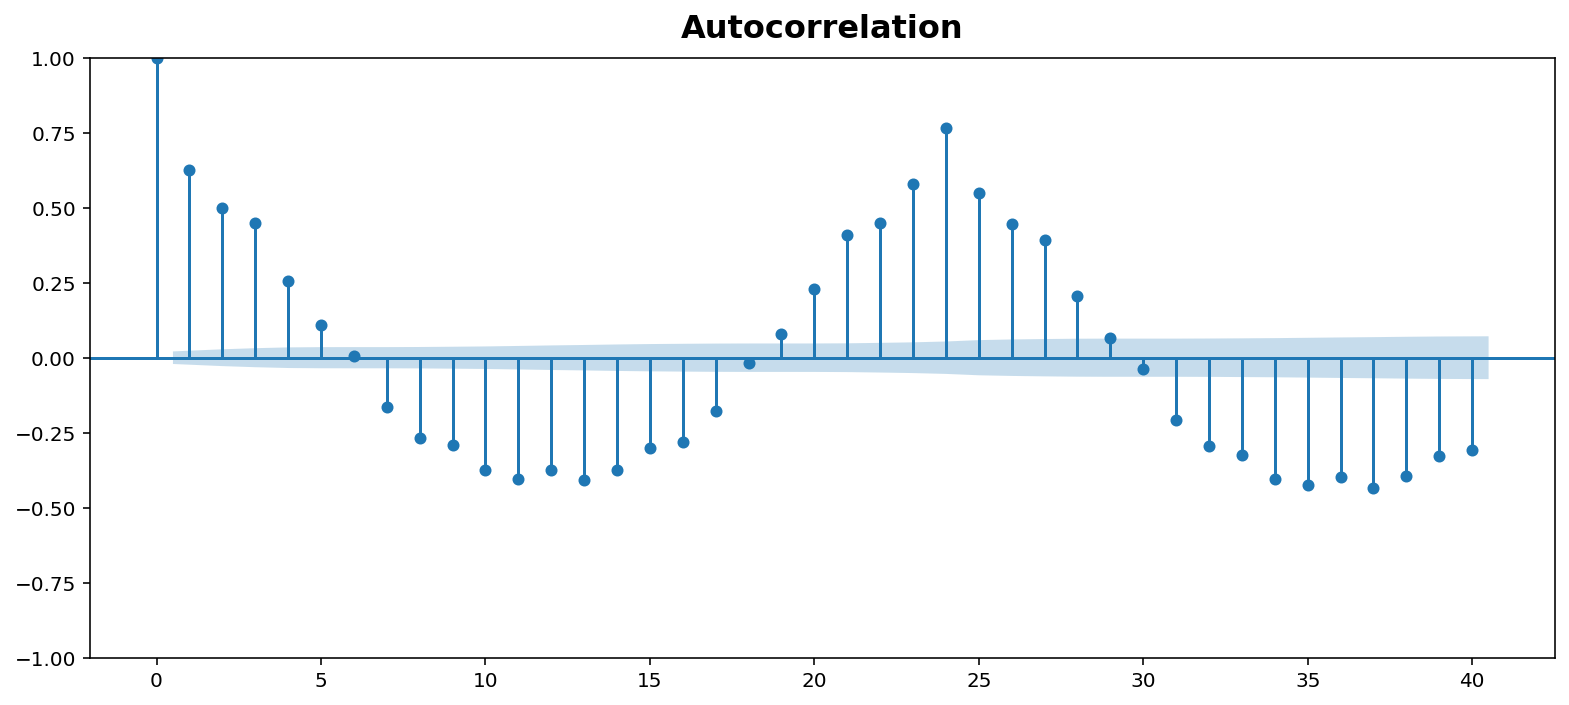

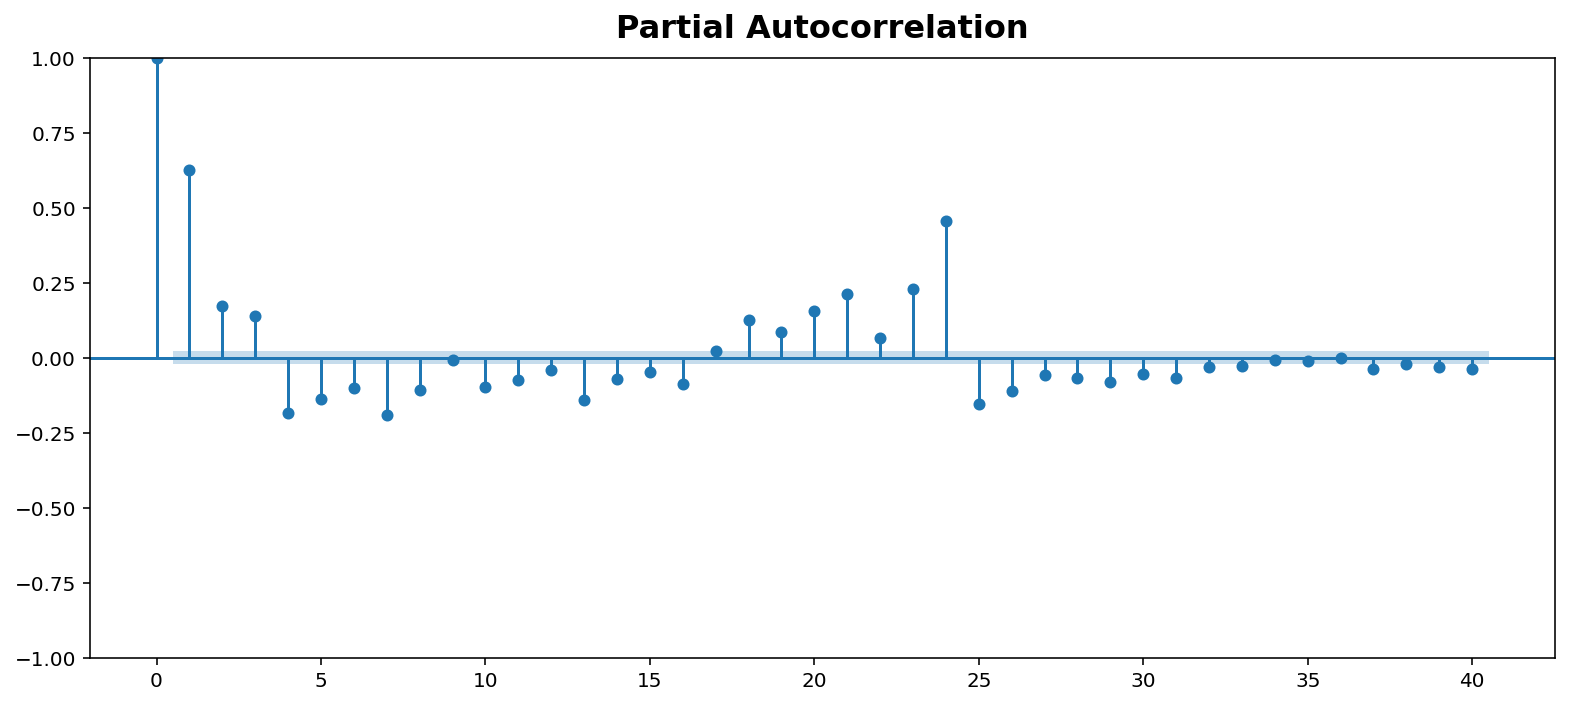

In [151]:
plot_acf(data['count'])
plot_pacf(data['count'])

Moving Average (Trend)

In [144]:
data['mov_avg'] = data['count'].rolling(
    window=24,
    center=True,
    min_periods=12
).mean()

data = data.dropna()

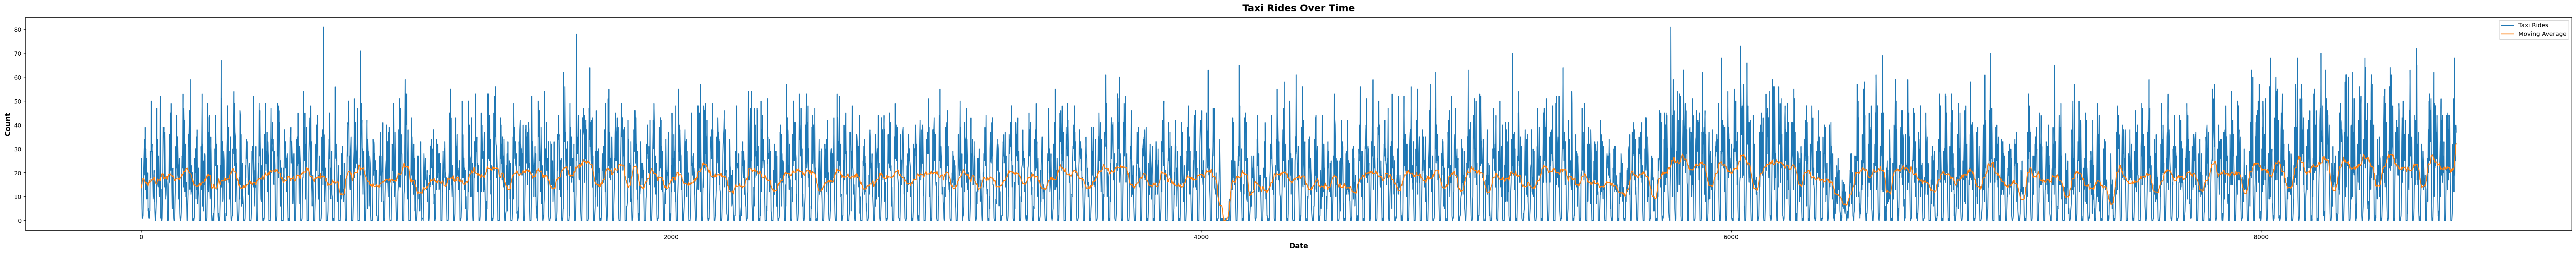

In [145]:
# plot moving average
plt.figure(figsize=(60, 6))
plt.plot(data['time'], data['count'], label='Taxi Rides')
plt.plot(data['time'], data['mov_avg'], label='Moving Average')
plt.title('Taxi Rides Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()

Seasonality
* seasonal plot
* periodogramm

In [136]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import seaborn as sns

In [137]:
#plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [138]:
data

count  time    mov_avg
date                                             
2022-04-01 00:00:00+00:00     26     1   9.600000
2022-04-01 01:00:00+00:00     15     2   8.166667
2022-04-01 02:00:00+00:00      5     3   7.142857
2022-04-01 03:00:00+00:00      1     4   7.285714
2022-04-01 04:00:00+00:00      1     5   5.428571
...                          ...   ...        ...
2023-03-30 18:00:00+00:00     34  8731  34.428571
2023-03-30 19:00:00+00:00     25  8732  34.428571
2023-03-30 20:00:00+00:00     25  8733  28.714286
2023-03-30 21:00:00+00:00     40  8734  31.500000
2023-03-30 22:00:00+00:00     37  8735  31.000000

[8735 rows x 3 columns]

In [139]:
seasondata = data.index.to_period('D')

/var/folders/q3/tk8ksh9n6233c6nj3njq87x80000gn/T/ipykernel_5736/866579240.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  seasondata = data.index.to_period('D')


In [140]:
X = seasondata.copy()

X['day'] = X.index.dayofweek
X['week'] = X.index.week
X['dayofyear'] = X.index.dayofyear
X['year'] = X.index.year

AttributeError: 'PeriodIndex' object has no attribute 'index'

In [ ]:
print(X['dayofyear'])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

NameError: name 'seasonal_plot' is not defined

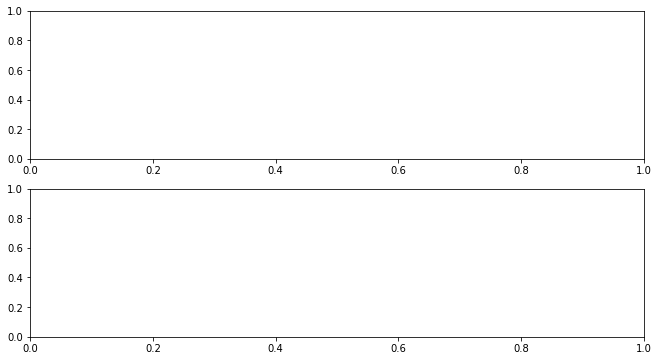

In [ ]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y=X["count"], period="week", freq="day", ax=ax0)
seasonal_plot(X, y=X["count"], period="year", freq="dayofyear", ax=ax1)
fig.savefig('/Users/paddy/Documents/GitHub/Masterthesis_ML/plots/TEMP_EDA_03_seasonalplot.png')

Periodogramm

In [ ]:
plot_periodogram(seasondata['count'])

NameError: name 'plot_periodogram' is not defined

Partial Autocorrelation function

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

In [ ]:
plot_pacf(seasondata['count'])
plot_acf(seasondata['count'])

NameError: name 'seasondata' is not defined

<Figure size 1080x504 with 0 Axes>

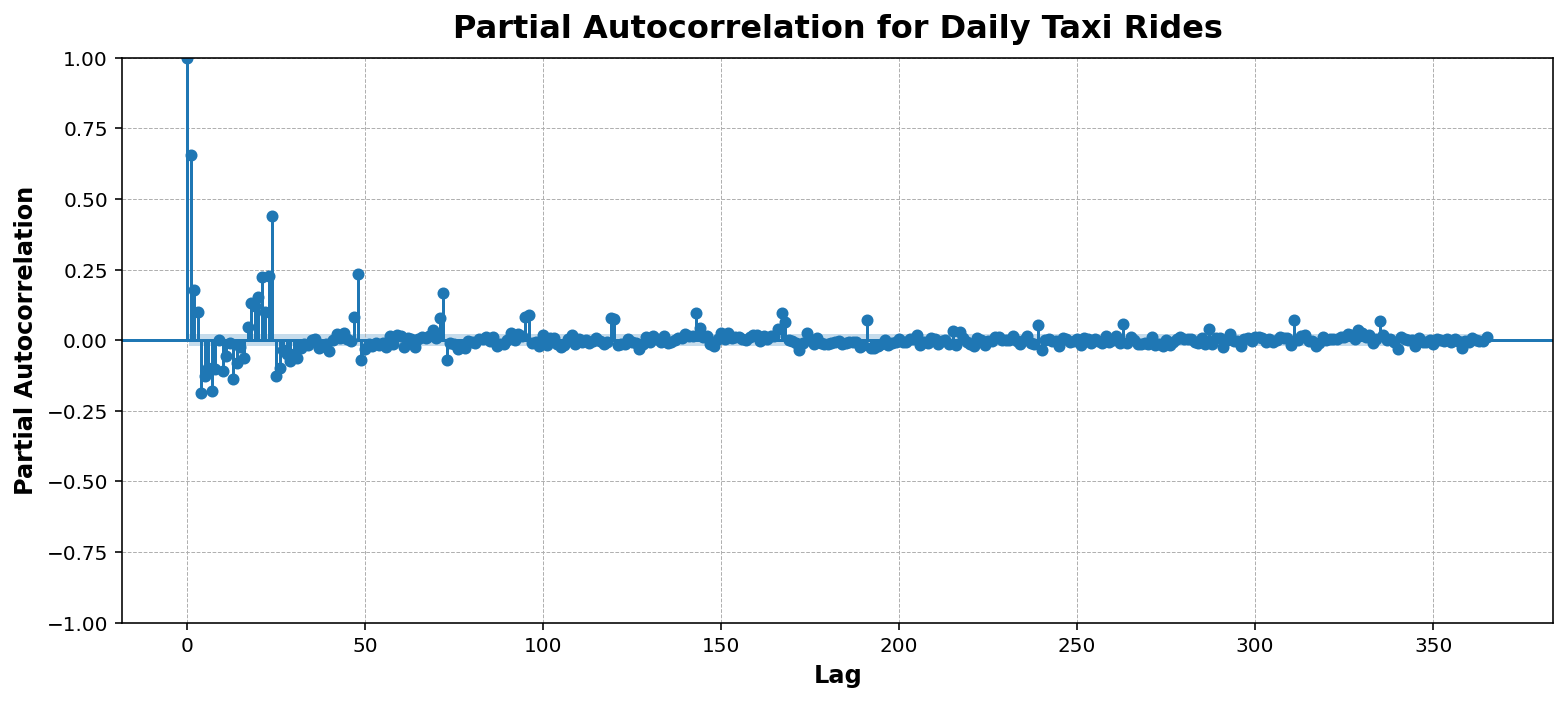

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

# Plot the Partial Autocorrelation Function (PACF) for the daily counts
plt.figure(figsize=(15, 7))
plot_pacf(data['count'], lags=365, title="Partial Autocorrelation for Daily Taxi Rides")
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

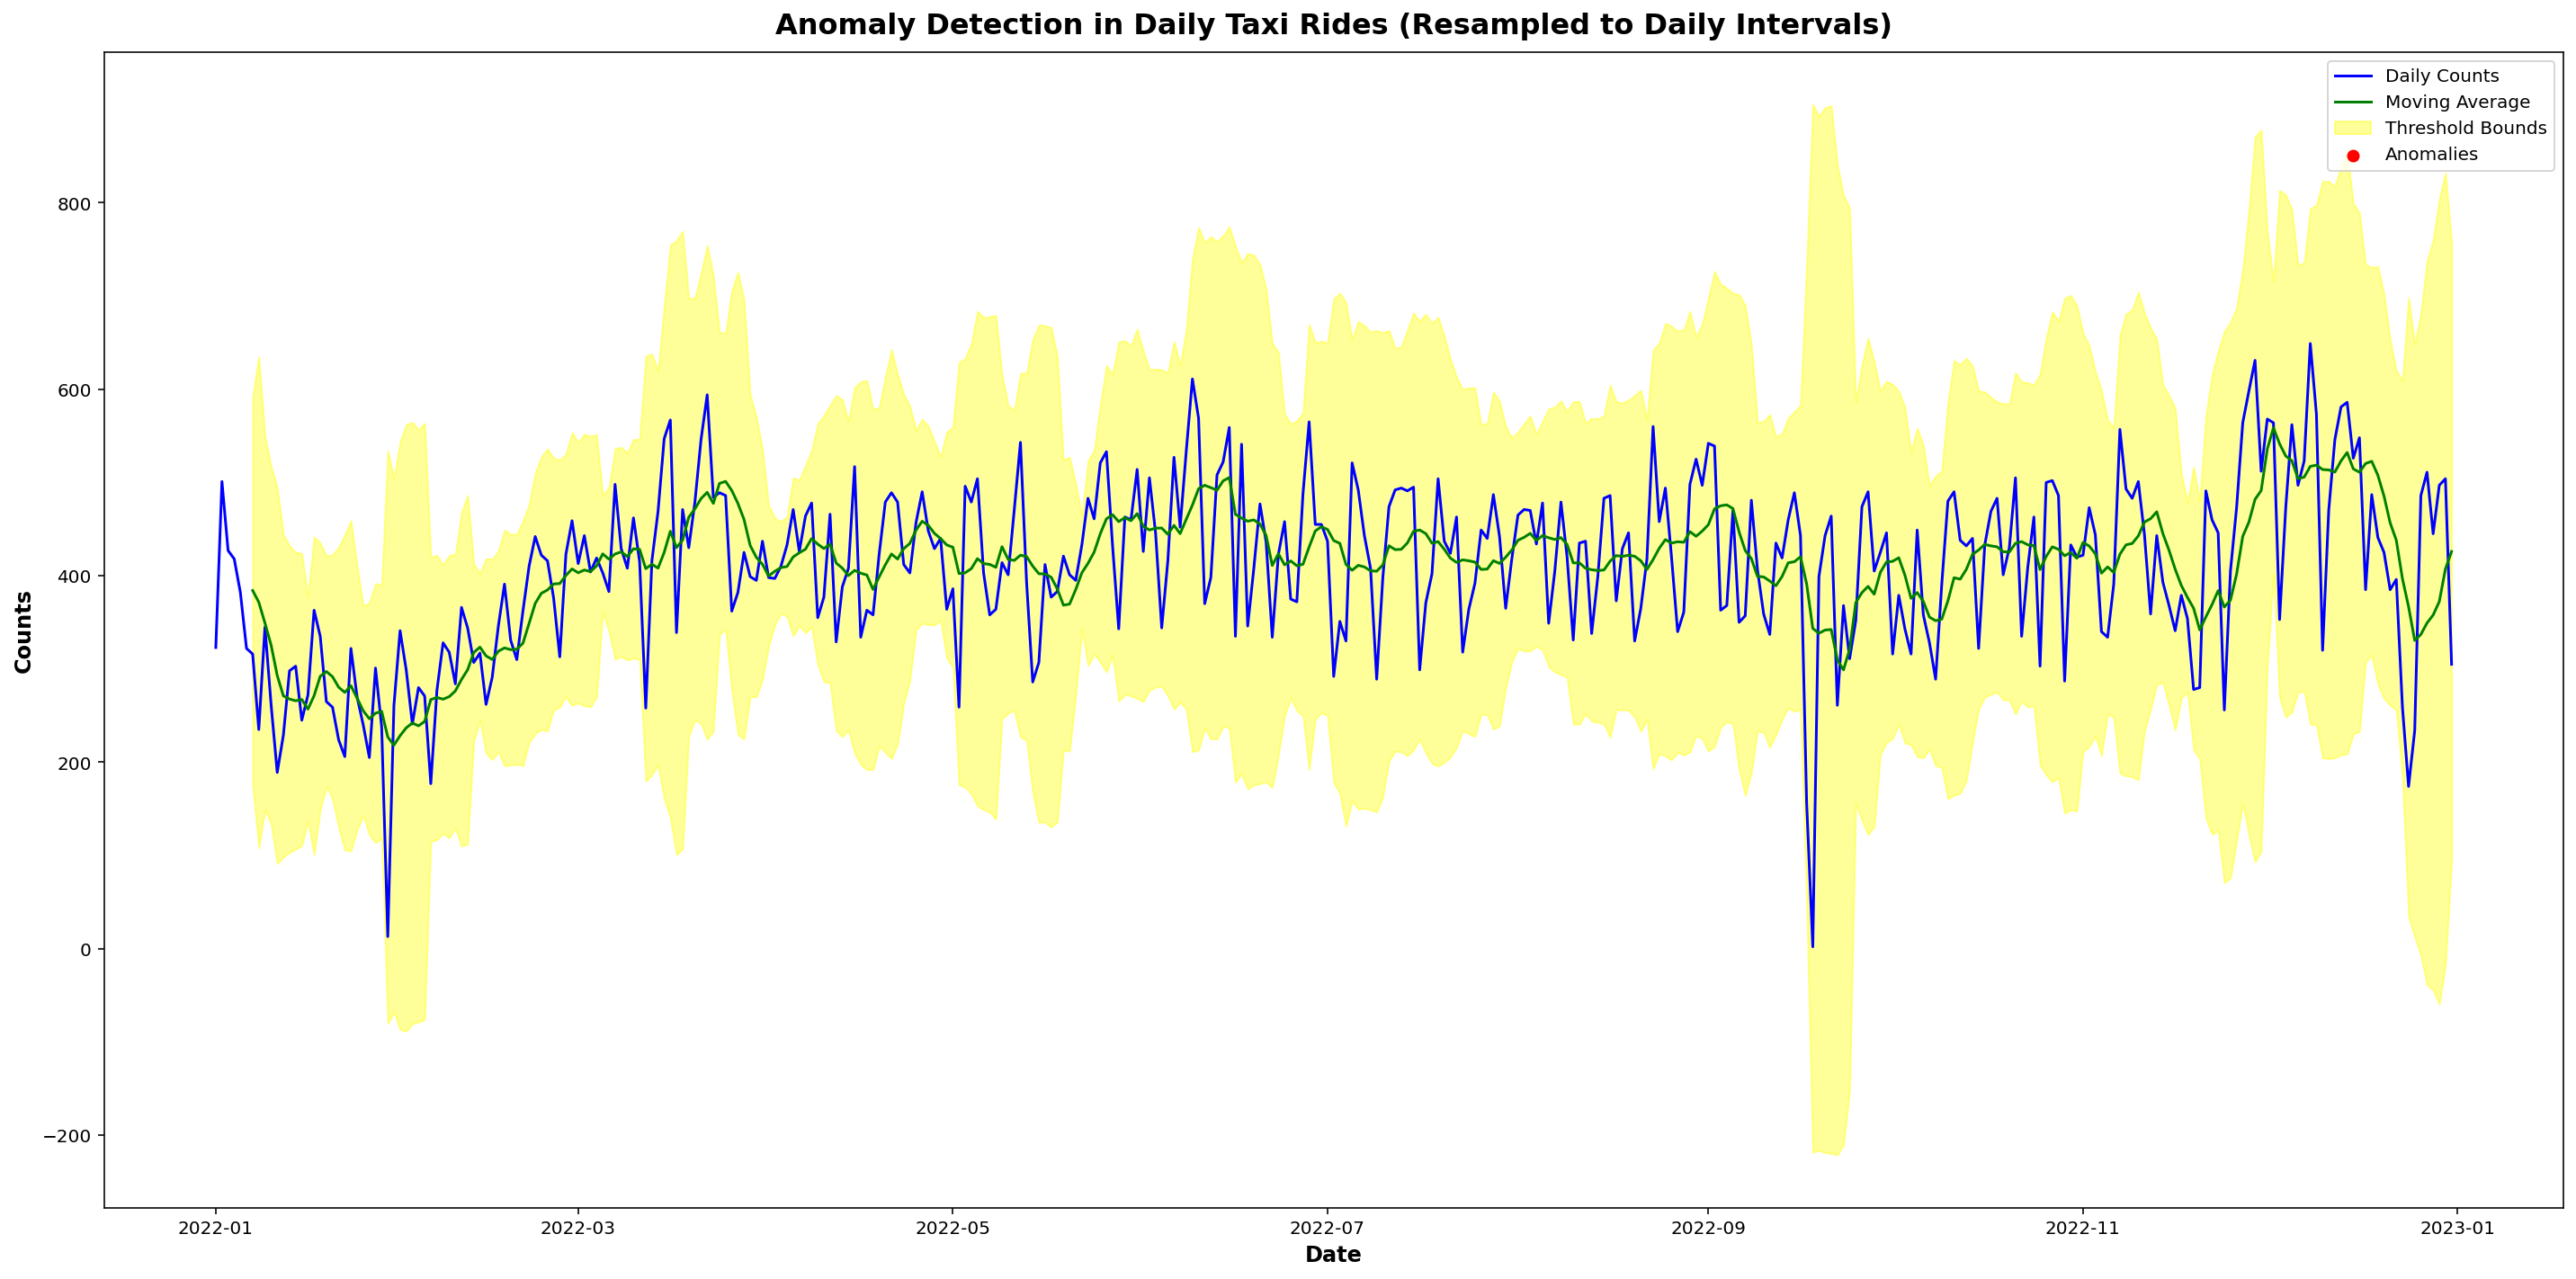

In [ ]:
# Resample the data at daily intervals
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
daily_taxi_rides = data.resample('D').sum()

window_size = 7
threshold = 3

# Compute the rolling mean and rolling standard deviation for the daily resampled data
rolling_mean_daily = daily_taxi_rides['count'].rolling(window=window_size).mean()
rolling_std_daily = daily_taxi_rides['count'].rolling(window=window_size).std()

# Define a threshold for anomaly detection (3 standard deviations from the moving average)
upper_bound_daily = rolling_mean_daily + (rolling_std_daily * threshold)
lower_bound_daily = rolling_mean_daily - (rolling_std_daily * threshold)

# Identify anomalies in the daily resampled data
anomalies_daily = daily_taxi_rides[(daily_taxi_rides['count'] > upper_bound_daily) | (daily_taxi_rides['count'] < lower_bound_daily)]

# Plot the daily resampled data, moving average, bounds, and anomalies
plt.figure(figsize=(20, 10))
plt.plot(daily_taxi_rides.index, daily_taxi_rides['count'], label='Daily Counts', color='blue')
plt.plot(daily_taxi_rides.index, rolling_mean_daily, label='Moving Average', color='green')
plt.fill_between(daily_taxi_rides.index, lower_bound_daily, upper_bound_daily, color='yellow', alpha=0.4, label='Threshold Bounds')
plt.scatter(anomalies_daily.index, anomalies_daily['count'], color='red', marker='o', label='Anomalies')
plt.title('Anomaly Detection in Daily Taxi Rides (Resampled to Daily Intervals)')
plt.xlabel('Date')
plt.ylabel('Counts')
plt.legend()
plt.tight_layout()
plt.show()
